# Introduction

This Notebook comes after the "fifa-ranking.ipynb" Notebook which created the training dataset with some basic features and defined target.
The goal is to make a exploratory data analysis and start to create more features for the modelling process.



image.png


## Features categories
All featurea are classified in a category.

### Odds
This group of feature are pure odds that can be find on bet website such as oddsportal.com or betexplorer.com. This is the known odds for a game at the opening stage. This category includes timeseries (odd evolution) from opening until the match day.

### Rolling
Rolling category includes all data for one team in a window (past, 3 or 5 last games). The purpose of this category is to highlight trend for expample last 3-5 games of a team or lastests opposition of the 2 teams to create numerical indicators.

### Ranking
This category includes all ranking of teams and scores. Often the 1:0 is more popular than 4:4 and this must be improved as features.

### Categorical
Data which qualify the game as the date, the season or the competition.

In [1]:
# load some libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import accuracy_score


In [2]:
# define some constant
FOLDER = 'dataset'
FILENAME = 'training_dataset.csv'
PATH = f'{FOLDER}/{FILENAME}'

In [3]:
#load the file and display info() and descriptions()
df = pd.read_csv(PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4371 entries, 0 to 4370
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   matchday             4371 non-null   object 
 1   home_team            4371 non-null   object 
 2   away_team            4371 non-null   object 
 3   season               4371 non-null   int64  
 4   competition          4371 non-null   object 
 5   correct_score        4371 non-null   object 
 6   1N2_1                4371 non-null   float64
 7   1N2_N                4371 non-null   float64
 8   1N2_2                4371 non-null   float64
 9   home_team_rank_FIFA  4371 non-null   float64
 10  away_team_rank_FIFA  4371 non-null   float64
 11  home_team_trend      4371 non-null   float64
 12  away_team_trend      4371 non-null   float64
 13  home_team_odd_trend  4371 non-null   float64
 14  away_team_odd_trend  4371 non-null   float64
 15  target               4371 non-null   f

In [4]:
# the dataset contains 2 prepared target value
# the target column contains the match result encoded 0=home winner, 1=draw, 2=away winner
# the best_odd_won indicates if the best odd (lowest value) won
categorical_cols = ['matchday', 'home_team', 'away_team', 'correct_score','competition','season']
target_cols =['target','best_odd_won']

df[categorical_cols + target_cols]

,matchday,home_team,away_team,correct_score,competition,season,target,best_odd_won
0,2002-05-31,France,Senegal,0:1,world-cup,2002,2.0,False
1,2002-06-01,Uruguay,Denmark,1:2,world-cup,2002,2.0,False
2,2002-06-01,Ireland,Cameroon,1:1,world-cup,2002,1.0,False
3,2002-06-01,Germany,Saudi Arabia,8:0,world-cup,2002,0.0,True
4,2002-06-02,Spain,Slovenia,3:1,world-cup,2002,0.0,True
...,...,...,...,...,...,...,...,...
4366,2021-07-03,Czech Republic,Denmark,1:2,euro,2020,2.0,True
4367,2021-07-03,Ukraine,England,0:4,euro,2020,2.0,True
4368,2021-07-06,Italy,Spain,2:1,euro,2020,0.0,True
4369,2021-07-07,England,Denmark,2:1,euro,2020,0.0,True


# Data Analysis
Get some insight from targets columns to evaluate distribution.

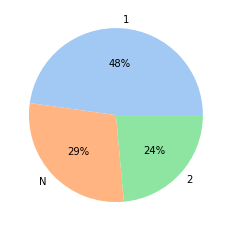

In [5]:
# define seaborn palette
colors = sns.color_palette('pastel')[0:5]

data = df.target.value_counts()
labels = ['1','N','2']
plt.pie(data.values, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

48% of the outcome of the game is a home winner, then away winner and draw game are equivalent 29% & 24%.
58% of the result concern the lowest odd.

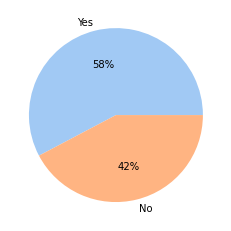

In [6]:
# define seaborn palette
colors = sns.color_palette('pastel')[0:5]

data = df.best_odd_won.value_counts()
labels = ['Yes','No']
plt.pie(data.values, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

In [7]:
pd.pivot_table(df[target_cols + ['correct_score']].groupby(target_cols).count().reset_index(), 
    values='correct_score', index='target', columns='best_odd_won', aggfunc=np.mean, fill_value=0)/df.shape[0]*100

<IPython.core.display.Javascript object>

best_odd_won,False,True
target,,
0.0,6.726150,41.066118
1.0,23.541524,0.000000
2.0,12.010981,16.655228


### Distribution best_odd_won and target analysis

41% of the games in the dataset have an issue of home team winner with lowest odd. 6% of the games are a home team winner but the odd is a surprise.
16% of the games are the away team to win the game with the lowest odd. This is the 58% of gameoutcome with the lowest odd.

In [8]:
def target_matrix(team=None):
    #team = 'Argentina'
    tm = df.query('home_team == @team or away_team == @team')
    print(f'Team: {team}. Size of {tm.shape[0]}')
    print(pd.pivot_table(tm[target_cols + ['correct_score']].groupby(target_cols).count().reset_index(), 
        values='correct_score', index='target', columns='best_odd_won', aggfunc=np.mean, fill_value=0)/tm.shape[0]*100) 
    return pd.pivot_table(tm[target_cols + ['correct_score']].groupby(target_cols).count().reset_index(), 
        values='correct_score', index='target', columns='best_odd_won', aggfunc=np.mean, fill_value=0)/tm.shape[0]*100


In [9]:
# create a sample of dataset
sp = df.copy()

# create a list of unique countries of sample dataset
lhome = sp.home_team.unique()
laway = sp.away_team.unique()

all_team=pd.DataFrame(np.concatenate((laway,lhome))).drop_duplicates()
all_team = all_team.iloc[:,0].tolist()
team_score = []
for team in all_team:
    # create a temporary dataframe with only team games
    tm = sp.query('home_team == @team or away_team == @team')
    xyz=pd.pivot_table(tm[target_cols + ['correct_score']].groupby(target_cols).count().reset_index(), 
        values='correct_score', index='target', columns='best_odd_won', aggfunc=np.mean, fill_value=0)/tm.shape[0]*100
    #print(f'{team} - {xyz} ')
    try:
        corr_score = abs(xyz.corr().iloc[0,1])
    except:
        corr_score = 0
    team_score.append([team, corr_score])
    
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
team_score = pd.DataFrame(team_score).fillna(0)
team_score.columns = ['team','score']

team_score_home = team_score.copy()
team_score_away = team_score.copy()

team_score_home.columns = ['team','corr_score_home']
team_score_away.columns = ['team','corr_score_away']

In [11]:
# merge with df
df=df.merge(team_score_home, left_on='home_team', right_on='team', how='left').drop('team', axis=1)
df=df.merge(team_score_away, left_on='away_team', right_on='team', how='left').drop('team', axis=1)
df.to_csv('dataset/training_dataset.csv')

In [12]:
df.shape

(4371, 19)

In [13]:
df.columns.tolist()

['matchday',
 'home_team',
 'away_team',
 'season',
 'competition',
 'correct_score',
 '1N2_1',
 '1N2_N',
 '1N2_2',
 'home_team_rank_FIFA',
 'away_team_rank_FIFA',
 'home_team_trend',
 'away_team_trend',
 'home_team_odd_trend',
 'away_team_odd_trend',
 'target',
 'best_odd_won',
 'corr_score_home',
 'corr_score_away']

In [14]:
try:
    df['corr_score_home']=df['corr_score_home_x']
    df['corr_score_away']=df['corr_score_home_y']
except:
    pass

    

In [15]:
df.head()

,matchday,home_team,away_team,season,competition,correct_score,1N2_1,1N2_N,1N2_2,home_team_rank_FIFA,away_team_rank_FIFA,home_team_trend,away_team_trend,home_team_odd_trend,away_team_odd_trend,target,best_odd_won,corr_score_home,corr_score_away
0,2002-05-31,France,Senegal,2002,world-cup,0:1,1.33,4.28,8.63,1.818182,38.454545,-1.0,-1.0,-1.0000,-1.0000,2.0,False,0.999099,0.984973
1,2002-06-01,Uruguay,Denmark,2002,world-cup,1:2,2.65,2.72,2.97,23.545455,15.727273,-1.0,-1.0,-1.0000,4.3675,2.0,False,0.785714,0.988381
2,2002-06-01,Ireland,Cameroon,2002,world-cup,1:1,3.33,2.90,2.28,54.727273,19.090909,8.0,-1.0,2.1125,5.7825,1.0,False,0.881049,1.000000
3,2002-06-01,Germany,Saudi Arabia,2002,world-cup,8:0,1.29,4.73,8.73,7.545455,35.818182,10.0,10.0,2.5325,2.1125,0.0,True,0.989398,0.858464
4,2002-06-02,Spain,Slovenia,2002,world-cup,3:1,1.42,4.10,7.57,5.090909,30.909091,11.0,6.0,1.7250,2.2550,0.0,True,0.973360,0.952510


In [16]:
df.best_odd_won.value_counts()

True     2523
False    1848
Name: best_odd_won, dtype: int64

In [17]:
temp = df.copy()
temp.shape

(4371, 19)

In [18]:
# before modeling I create a spare dataset with 2018 world cup game and delete them from the training set
print(df.shape)

wc = df.query('competition == "world-cup" and season == 2018', engine='python').copy()
ind = df.query('competition == "world-cup" and season == 2018', engine='python').index.tolist()
df.drop(ind, inplace = True)

#df = df.query('competition != "world-cup" and season != 2018', engine='python').copy()
wc.to_csv(f'{FOLDER}/wc_2018.csv')
wc.shape, df.shape


(4371, 19)


((64, 19), (4307, 19))

# Modeling

## Strategy

The model process will be done with more than 1 model. A first model is called to predict if the lowest odd will win or if the 2 other.

If the prediction is not 1 so a second model trained with only 2 odds will be called to decide wich one will be predicted.

At the end of this stage (1 prediction if 1st one is the lowest or 2) we will know the target for the regressor
1
N
2
These 3 models would be trained as regressor.


## 1st Model - Best Odd Won ?
Set the features which will fit to the training phase.
Set the target.

In [19]:
# define features
features = ['1N2_1','1N2_N','1N2_2','home_team_rank_FIFA','home_team_trend','home_team_odd_trend','corr_score_home',
                                    'away_team_rank_FIFA','away_team_trend','away_team_odd_trend','corr_score_away']

df['best_odd_won'] *=1

In [20]:
df.best_odd_won.value_counts()

1    2484
0    1823
Name: best_odd_won, dtype: int64

In [21]:
X = df[features].values
y = df.best_odd_won

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PowerTransformer


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [24]:
steps = [('scaler', StandardScaler()),('power',PowerTransformer()) ,('SVM', SVC())]
steps = [('scaler', StandardScaler()) ,('SVM', SVC())]
pipeline = Pipeline(steps)
parameteres = {'SVM__C':[40,45,47], 'SVM__gamma':[0.01]}
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)

grid.fit(X_train, y_train)
print(grid.score(X_test,y_test))
print(grid.best_params_)


0.7812939521800282
{'SVM__C': 40, 'SVM__gamma': 0.01}


In [26]:
steps = [('scaler', StandardScaler()), ('power',PowerTransformer()) ,('DT', DecisionTreeClassifier())]
pipeline = Pipeline(steps)
parameteres = {'DT__class_weight':[{0:1848,1:2523}], 'DT__max_depth':[5,10,30,None], 'DT__criterion':['gini','entropy']}
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)

grid.fit(X_train, y_train)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.7165963431786216
{'DT__class_weight': {0: 1848, 1: 2523}, 'DT__criterion': 'gini', 'DT__max_depth': None}


In [27]:
extra_tree = ExtraTreeClassifier(random_state=0)
steps = [('scaler', StandardScaler()),('power',PowerTransformer()) , ('ET', ExtraTreeClassifier(random_state=0))]
pipeline = Pipeline(steps)
parameteres = {'ET__class_weight':[{0:1848,1:2523}], 'ET__max_depth':[5,10,30,None], 'ET__criterion':['gini','entropy']}
grid = GridSearchCV(pipeline, 
        param_grid=parameteres, 
        cv=5)

grid.fit(X_train, y_train)
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.6751054852320675
{'ET__class_weight': {0: 1848, 1: 2523}, 'ET__criterion': 'entropy', 'ET__max_depth': 10}


In [28]:
steps = [('scaler', StandardScaler()),('power',PowerTransformer()) , ('LR', LogisticRegression())]
pipeline = Pipeline(steps)
parameteres = {'LR__class_weight':[{0:1848,1:2523}], 'LR__max_iter':[1000,1300], 'LR__solver':['lbfgs','saga']}
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)

grid.fit(X_train, y_train)
print(grid.score(X_test,y_test))
print(grid.best_params_)

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/skle

0.729957805907173
{'LR__class_weight': {0: 1848, 1: 2523}, 'LR__max_iter': 1000, 'LR__solver': 'lbfgs'}


/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [29]:
xgb_cl = xgb.XGBClassifier()

In [30]:
# Fit

scaler = StandardScaler()
scaler.fit(X_train)
X_train_processed = scaler.transform(X_train)
X_test_processed = scaler.transform(X_test)


xgb_cl.fit(X_train_processed, y_train)

# Predict
preds = xgb_cl.predict(X_test_processed)

# Score
accuracy_score(y_test, preds)


0.7918424753867792

In [31]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

param_grid = {
    "max_depth": [3],
    "learning_rate": [0.1,0.3,0.5,0.7,1],
    "gamma": [0,3,5,7],
    "reg_lambda": [0,10,30,50],
    "scale_pos_weight": [1,3],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [32]:
# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_test_processed, y_test)

In [33]:
grid_cv.best_score_

0.859455057824623

In [34]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 7,
 'learning_rate': 0.1,
 'max_depth': 3,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [35]:
preds=grid_cv.predict(X_test_processed)

# Score
accuracy_score(y_test, preds)


0.8255977496483825

In [36]:
X_test[0]

array([ 2.52      ,  3.19      ,  2.46      , 12.91666667, 12.        ,
        1.6125    ,  0.99927447, 16.25      ,  8.        ,  2.845     ,
        0.98939824])

In [37]:
# define features
features = ['1N2_1','1N2_N','1N2_2','home_team_rank_FIFA','home_team_trend','home_team_odd_trend','corr_score_home',
                                    'away_team_rank_FIFA','away_team_trend','away_team_odd_trend','corr_score_away']

In [38]:
p1= grid_cv.predict_proba(X_test[0].reshape(1,-1))
p1, y_test[0]


(array([[0.5452732, 0.4547268]], dtype=float32), 0)

In [39]:

import joblib

#save your model or results
joblib.dump(grid_cv, 'models/best_odd_won.pkl')

#load your model for further usage
joblib.load("models/best_odd_won.pkl")

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                        

In [40]:
model_bow = joblib.load("models/best_odd_won.pkl")

In [41]:
p1= model_bow.predict_proba(X_test[0].reshape(1,-1))
p1, y_test[0]

(array([[0.5452732, 0.4547268]], dtype=float32), 0)

## 2nd Model - Best odd was not predicted

To train the model, features (best lowest odd) will be removed form the dataset.

In [42]:
# make a copy of the original dataset 
df2 = df[features].copy()
df2[['odd_min','odd_max']]=np.nan
df2

,1N2_1,1N2_N,1N2_2,home_team_rank_FIFA,home_team_trend,home_team_odd_trend,corr_score_home,away_team_rank_FIFA,away_team_trend,away_team_odd_trend,corr_score_away,odd_min,odd_max
0,1.33,4.28,8.63,1.818182,-1.0,-1.0000,0.999099,38.454545,-1.0,-1.0000,0.984973,NaN,NaN
1,2.65,2.72,2.97,23.545455,-1.0,-1.0000,0.785714,15.727273,-1.0,4.3675,0.988381,NaN,NaN
2,3.33,2.90,2.28,54.727273,8.0,2.1125,0.881049,19.090909,-1.0,5.7825,1.000000,NaN,NaN
3,1.29,4.73,8.73,7.545455,10.0,2.5325,0.989398,35.818182,10.0,2.1125,0.858464,NaN,NaN
4,1.42,4.10,7.57,5.090909,11.0,1.7250,0.973360,30.909091,6.0,2.2550,0.952510,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4366,3.94,3.08,2.13,40.666667,9.0,1.9425,0.884615,10.666667,9.0,2.0625,0.988381,NaN,NaN
4367,7.64,3.98,1.52,24.000000,12.0,1.8250,0.956146,4.000000,12.0,2.0300,0.949018,NaN,NaN
4368,2.50,3.14,3.10,8.000000,9.0,2.0100,0.873981,6.000000,9.0,1.9175,0.973360,NaN,NaN
4369,1.75,3.44,5.58,4.000000,12.0,2.0675,0.949018,10.666667,9.0,2.1250,0.988381,NaN,NaN


In [43]:
# remove lowest odd
# create 2 columns odd_A odd_B

for idx, r in df2.iterrows():
    o1 = r['1N2_1']
    oN = r['1N2_N']
    o2 = r['1N2_2']
    t = sorted([o1,oN,o2])
    df2.loc[idx,'odd_min']=t[1]
    df2.loc[idx,'odd_max']=t[2]
df2.drop(['1N2_1','1N2_N','1N2_2'], axis=1, inplace=True)
df2

,home_team_rank_FIFA,home_team_trend,home_team_odd_trend,corr_score_home,away_team_rank_FIFA,away_team_trend,away_team_odd_trend,corr_score_away,odd_min,odd_max
0,1.818182,-1.0,-1.0000,0.999099,38.454545,-1.0,-1.0000,0.984973,4.28,8.63
1,23.545455,-1.0,-1.0000,0.785714,15.727273,-1.0,4.3675,0.988381,2.72,2.97
2,54.727273,8.0,2.1125,0.881049,19.090909,-1.0,5.7825,1.000000,2.90,3.33
3,7.545455,10.0,2.5325,0.989398,35.818182,10.0,2.1125,0.858464,4.73,8.73
4,5.090909,11.0,1.7250,0.973360,30.909091,6.0,2.2550,0.952510,4.10,7.57
...,...,...,...,...,...,...,...,...,...,...
4366,40.666667,9.0,1.9425,0.884615,10.666667,9.0,2.0625,0.988381,3.08,3.94
4367,24.000000,12.0,1.8250,0.956146,4.000000,12.0,2.0300,0.949018,3.98,7.64
4368,8.000000,9.0,2.0100,0.873981,6.000000,9.0,1.9175,0.973360,3.10,3.14
4369,4.000000,12.0,2.0675,0.949018,10.666667,9.0,2.1250,0.988381,3.44,5.58


In [44]:
df2.columns.tolist()

['home_team_rank_FIFA',
 'home_team_trend',
 'home_team_odd_trend',
 'corr_score_home',
 'away_team_rank_FIFA',
 'away_team_trend',
 'away_team_odd_trend',
 'corr_score_away',
 'odd_min',
 'odd_max']

In [45]:
X = df2.values
y = df.target

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


scaler = StandardScaler()
scaler.fit(X_train)
X_train_processed = scaler.transform(X_train)
X_test_processed = scaler.transform(X_test)


In [47]:
# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_test_processed, y_test)

[16:22:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:22:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:22:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[16:23:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring


[16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-

/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/darylfelix/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring

[16:23:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [48]:
preds=grid_cv.predict(X_test_processed)

# Score
accuracy_score(y_test, preds)


0.819268635724332

In [49]:
p1_1 = grid_cv.predict_proba(X_test_processed[0].reshape(1,-1))

In [50]:
X_test_processed[0]

array([-1.02434445,  1.36544218, -0.98833887,  0.78888981, -1.04160906,
       -0.04925465,  0.17216739,  0.7278795 , -0.61319923, -0.49510479])

In [51]:
p1_1

array([[0.86123925, 0.03796461, 0.10079614]], dtype=float32)

In [52]:
y_test[0]

2.0

In [53]:

#save your model or results
joblib.dump(grid_cv, 'models/non_best_odd_won_predict_1N2.pkl')

#load your model for further usage
joblib.load("models/non_best_odd_won_predict_1N2.pkl")

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                        

## Train a model on best (lowest) odd won and target.

In [54]:
df3=df.copy()

# keep only best odd (lowest) won

df3 = df3.query('best_odd_won ==1')
df3['target']=df3.target/2
df3.shape



(2484, 19)

In [55]:
df3.target.value_counts()

0.0    1774
1.0     710
Name: target, dtype: int64

In [56]:
features

['1N2_1',
 '1N2_N',
 '1N2_2',
 'home_team_rank_FIFA',
 'home_team_trend',
 'home_team_odd_trend',
 'corr_score_home',
 'away_team_rank_FIFA',
 'away_team_trend',
 'away_team_odd_trend',
 'corr_score_away']

In [57]:
for idx, r in df3.iterrows():
    o1 = r['1N2_1']
    oN = r['1N2_N']
    o2 = r['1N2_2']
    t = sorted([o1,oN,o2])
    df3.loc[idx,'lowest_odd']=t[0]

df3.drop(['1N2_1','1N2_N','1N2_2'], axis=1, inplace=True)
df3

,matchday,home_team,away_team,season,competition,correct_score,home_team_rank_FIFA,away_team_rank_FIFA,home_team_trend,away_team_trend,home_team_odd_trend,away_team_odd_trend,target,best_odd_won,corr_score_home,corr_score_away,lowest_odd
3,2002-06-01,Germany,Saudi Arabia,2002,world-cup,8:0,7.545455,35.818182,10.0,10.0,2.5325,2.1125,0.0,1,0.989398,0.858464,1.29
4,2002-06-02,Spain,Slovenia,2002,world-cup,3:1,5.090909,30.909091,11.0,6.0,1.7250,2.2550,0.0,1,0.973360,0.952510,1.42
7,2002-06-02,Argentina,Nigeria,2002,world-cup,1:0,3.272727,30.000000,9.0,6.0,2.3150,2.3750,0.0,1,0.981473,0.787146,1.66
8,2002-06-03,Brazil,Turkey,2002,world-cup,2:1,1.727273,15.909091,8.0,9.0,1.4625,2.3800,0.0,1,0.995454,0.999274,1.43
9,2002-06-03,Italy,Ecuador,2002,world-cup,2:0,8.363636,33.818182,8.0,8.0,2.3050,1.8800,0.0,1,0.873981,0.898286,1.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4365,2021-07-02,Belgium,Italy,2020,euro,1:2,1.000000,8.000000,9.0,12.0,2.8550,1.9950,1.0,1,0.920483,0.873981,2.34
4366,2021-07-03,Czech Republic,Denmark,2020,euro,1:2,40.666667,10.666667,9.0,9.0,1.9425,2.0625,1.0,1,0.884615,0.988381,2.13
4367,2021-07-03,Ukraine,England,2020,euro,0:4,24.000000,4.000000,12.0,12.0,1.8250,2.0300,1.0,1,0.956146,0.949018,1.52
4368,2021-07-06,Italy,Spain,2020,euro,2:1,8.000000,6.000000,9.0,9.0,2.0100,1.9175,0.0,1,0.873981,0.973360,2.50


In [58]:
# define features
features = ['lowest_odd','home_team_rank_FIFA','home_team_trend','home_team_odd_trend','corr_score_home',
                                    'away_team_rank_FIFA','away_team_trend','away_team_odd_trend','corr_score_away']

X = df3[features].values
y = df3.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


scaler = StandardScaler()
scaler.fit(X_train)
X_train_processed = scaler.transform(X_train)
X_test_processed = scaler.transform(X_test)


In [59]:
# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_test_processed, y_test)

In [60]:
preds=grid_cv.predict(X_test_processed)

# Score
accuracy_score(y_test, preds)


0.9597560975609756

In [61]:
p1_2 = grid_cv.predict_proba(X_test_processed[0].reshape(1,-1))
p1_2

array([[0.9264779 , 0.07352207]], dtype=float32)

In [62]:
# outcomes prediction is 0 = home win, 1 = away win

In [63]:
#save your model or results
joblib.dump(grid_cv, 'models/best_odd_won_predict_1-2.pkl')

#load your model for further usage
joblib.load("models/best_odd_won_predict_1-2.pkl")

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                        

## Multi-Output Regressor

To define the correct score of the predicted game and based on the prediction of the classification proble, 3 multi-output regressor will be trained based on the split of target (1;N;2) with the correct score as target values.



In [64]:
# prepare 3 dataframes for each of the outcomes of the game 1;N;2
df.target.value_counts()

0.0    2062
2.0    1225
1.0    1020
Name: target, dtype: int64

In [65]:
# create home_score and away_score columns
for idx, r in df.iterrows():
    score = r.correct_score.split(':')
    df.loc[idx,'home_score']=score[0]
    df.loc[idx,'away_score']=score[1]

df

,matchday,home_team,away_team,season,competition,correct_score,1N2_1,1N2_N,1N2_2,home_team_rank_FIFA,...,home_team_trend,away_team_trend,home_team_odd_trend,away_team_odd_trend,target,best_odd_won,corr_score_home,corr_score_away,home_score,away_score
0,2002-05-31,France,Senegal,2002,world-cup,0:1,1.33,4.28,8.63,1.818182,...,-1.0,-1.0,-1.0000,-1.0000,2.0,0,0.999099,0.984973,0,1
1,2002-06-01,Uruguay,Denmark,2002,world-cup,1:2,2.65,2.72,2.97,23.545455,...,-1.0,-1.0,-1.0000,4.3675,2.0,0,0.785714,0.988381,1,2
2,2002-06-01,Ireland,Cameroon,2002,world-cup,1:1,3.33,2.90,2.28,54.727273,...,8.0,-1.0,2.1125,5.7825,1.0,0,0.881049,1.000000,1,1
3,2002-06-01,Germany,Saudi Arabia,2002,world-cup,8:0,1.29,4.73,8.73,7.545455,...,10.0,10.0,2.5325,2.1125,0.0,1,0.989398,0.858464,8,0
4,2002-06-02,Spain,Slovenia,2002,world-cup,3:1,1.42,4.10,7.57,5.090909,...,11.0,6.0,1.7250,2.2550,0.0,1,0.973360,0.952510,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4366,2021-07-03,Czech Republic,Denmark,2020,euro,1:2,3.94,3.08,2.13,40.666667,...,9.0,9.0,1.9425,2.0625,2.0,1,0.884615,0.988381,1,2
4367,2021-07-03,Ukraine,England,2020,euro,0:4,7.64,3.98,1.52,24.000000,...,12.0,12.0,1.8250,2.0300,2.0,1,0.956146,0.949018,0,4
4368,2021-07-06,Italy,Spain,2020,euro,2:1,2.50,3.14,3.10,8.000000,...,9.0,9.0,2.0100,1.9175,0.0,1,0.873981,0.973360,2,1
4369,2021-07-07,England,Denmark,2020,euro,2:1,1.75,3.44,5.58,4.000000,...,12.0,9.0,2.0675,2.1250,0.0,1,0.949018,0.988381,2,1


In [66]:
# define features
features = ['1N2_1','1N2_N','1N2_2','home_team_rank_FIFA','home_team_trend','home_team_odd_trend','corr_score_home',
                                    'away_team_rank_FIFA','away_team_trend','away_team_odd_trend','corr_score_away']

In [67]:
df_1 = df.query('target == 0').copy() #home winner
df_N = df.query('target == 1').copy() #no winner
df_2 = df.query('target == 2').copy() #away winner

df_1.shape, df_N.shape, df_2.shape


((2062, 21), (1020, 21), (1225, 21))

In [68]:
import numpy as np 
import pandas as pd 
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import absolute

model_names = ['model_home_winner_score','model_draw_game_score','model_away_winner_score']
criterias  = [0,1,2]
predictions = []
results = []
i=0
for c in criterias:

    X = df.query('target == @c')[features].values
    y = df.query('target == @c')[['home_score','away_score']].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)


    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_processed = scaler.transform(X_train)
    X_test_processed = scaler.transform(X_test)

    # fitting
    multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X_train_processed, y_train)
    prediction = multioutputregressor.predict(X_test_processed).astype(int)
    predictions.append(prediction)

    mor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(mor, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    n_scores = absolute(n_scores)
    print(f'Score MAE: {np.mean(n_scores)}, STD: {np.std(n_scores)} - model name {model_names[i]}')
    results.append([c, model_names[i] ,f'Score MAE: {np.mean(n_scores)}, STD: {np.std(n_scores)}'])

    print(multioutputregressor.n_features_in_)
    #save your model or results
    joblib.dump(multioutputregressor, f'models/{model_names[i]}.pkl')

    #load your model for further usage
    joblib.load(f"models/{model_names[i]}.pkl")

    i=i+1

    


Score MAE: 0.8350402653152094, STD: 0.03404738111986535 - model name model_home_winner_score
11
Score MAE: 0.680898182973375, STD: 0.05395007286177238 - model name model_draw_game_score
11
Score MAE: 0.7836146352629892, STD: 0.04411622163569048 - model name model_away_winner_score
11


In [69]:
X_train.shape

(820, 11)